In [8]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pathlib import Path

In [9]:
# Load the data as pandas dataframe
energy_file_path = Path.home() / 'Documents' / 'datasets' / 'spain_energy' / 'energy_dataset.csv'
weather_file_path = Path.home() / 'Documents' / 'datasets' / 'spain_energy' / 'weather_features.csv'

energy_df = pd.read_csv(energy_file_path, parse_dates=['time'])
weather_df = pd.read_csv(weather_file_path, parse_dates=['dt_iso'])

In [10]:
# Change the time column to datetime and set it as index
weather_df = weather_df.rename(columns={'dt_iso': 'time'})
weather_df['time'] = pd.to_datetime(weather_df['time'], utc=True)
weather_df = weather_df.set_index('time')

# Fill in NaN values using linear interpolation
weather_df.interpolate(method='linear', inplace=True, limit_direction='forward')

weather_df.head()

,time,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [11]:
# Remove columns that are not needed
energy_df = energy_df.drop(columns=['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 
                                    'generation hydro pumped storage aggregated', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead',
                                    'total load forecast', 'forecast solar day ahead', 'forecast wind onshore day ahead'], axis=1)

# Convert time to datetime format
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)
energy_df = energy_df.set_index('time')

# Fill in NaN values using linear interpolation
energy_df.interpolate(method='linear', inplace=True, limit_direction='forward')

energy_df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04


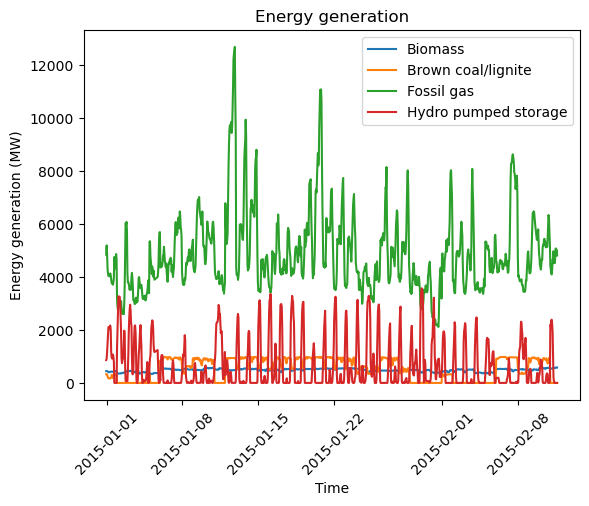

In [21]:
# Plot a sample of the energy data
plt.plot(energy_df.iloc[0:1000].index, energy_df['generation biomass'].iloc[0:1000])
plt.plot(energy_df.iloc[0:1000].index, energy_df['generation fossil brown coal/lignite'].iloc[0:1000])
plt.plot(energy_df.iloc[0:1000].index, energy_df['generation fossil gas'].iloc[0:1000])
plt.plot(energy_df.iloc[0:1000].index, energy_df['generation hydro pumped storage consumption'].iloc[0:1000])
plt.xlabel('Time')
plt.ylabel('Energy generation (MW)')
plt.title('Energy generation')
plt.legend(['Biomass', 'Brown coal/lignite', 'Fossil gas', 'Hydro pumped storage'])
plt.xticks(rotation=45)
plt.show()